In [397]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Wczytanie i preprocessing danych

In [398]:
house_data = pd.read_csv("train_data.csv")

print(house_data.N_elevators.describe())

count    4124.000000
mean       11.055771
std         7.717030
min         0.000000
25%         5.000000
50%        11.000000
75%        16.000000
max        27.000000
Name: N_elevators, dtype: float64


In [399]:
house_data = house_data.drop(columns=[])
house_data.HeatingType = (house_data.HeatingType == "individual_heating").astype(int)
house_data.AptManageType = (house_data.AptManageType == "management_in_trust").astype(int)

categorical_columns = house_data.select_dtypes(include=['object']).columns
house_data = pd.get_dummies(house_data, columns=categorical_columns)

# We have 3 classes - 1. SalePrice < 100000, 2. 1000000 <= SalePrice < 350000, 3. SalePrice >= 350000
house_data['SalePrice'] = pd.cut(house_data['SalePrice'], bins=[0, 100000, 350000, 1000000], labels=[0, 1, 2])
house_data = pd.get_dummies(house_data, columns=['SalePrice'])

# -> int
house_data = house_data.astype(int)

house_data.head()

,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,...,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby,SalePrice_0,SalePrice_1,SalePrice_2
0,2006,814,3,1,1,111,184,3,0,5,...,0,0,0,1,0,0,0,0,1,0
1,1985,587,8,1,0,80,76,2,2,3,...,0,0,1,0,0,0,0,1,0,0
2,1985,587,6,1,0,80,76,2,2,3,...,0,0,1,0,0,0,0,1,0,0
3,2006,2056,8,1,1,249,536,5,11,5,...,0,0,0,0,0,1,0,0,0,1
4,1992,644,2,1,0,142,79,4,8,3,...,0,0,0,0,1,0,0,1,0,0


## Niezbalansowanie danych

In [400]:
print(house_data['SalePrice_0'].sum())
print(house_data['SalePrice_1'].sum())
print(house_data['SalePrice_2'].sum())

562
2992
570


## Przygotowanie zbiorów

In [401]:
train = house_data.sample(frac=0.8, random_state=42) 
test = house_data.drop(train.index)

# Shape
print(train.dtypes)

YearBuilt                              int64
Size(sqf)                              int64
Floor                                  int64
HeatingType                            int64
AptManageType                          int64
N_Parkinglot(Ground)                   int64
N_Parkinglot(Basement)                 int64
N_manager                              int64
N_elevators                            int64
N_FacilitiesInApt                      int64
N_FacilitiesNearBy(Total)              int64
N_SchoolNearBy(Total)                  int64
HallwayType_corridor                   int64
HallwayType_mixed                      int64
HallwayType_terraced                   int64
TimeToBusStop_0~5min                   int64
TimeToBusStop_10min~15min              int64
TimeToBusStop_5min~10min               int64
TimeToSubway_0-5min                    int64
TimeToSubway_10min~15min               int64
TimeToSubway_15min~20min               int64
TimeToSubway_5min~10min                int64
TimeToSubw

In [402]:
train_y = train[['SalePrice_0', 'SalePrice_1', 'SalePrice_2']]
train_x = train.drop(columns=['SalePrice_0', 'SalePrice_1', 'SalePrice_2'])
test_y = test[['SalePrice_0', 'SalePrice_1', 'SalePrice_2']]
test_x = test.drop(columns=['SalePrice_0', 'SalePrice_1', 'SalePrice_2'])

# Normalize data
train_x = (train_x - train_x.mean()) / train_x.std()
test_x = (test_x - test_x.mean()) / test_x.std()

In [403]:
import torch
import numpy as np
import torch.utils.data as data
import torch.nn as nn

train_dataset = data.TensorDataset(
    torch.from_numpy(train_x.values), torch.from_numpy(train_y.values)
)
test_dataset = data.TensorDataset(
    torch.from_numpy(test_x.values), torch.from_numpy(test_y.values)
)

next(iter(train_dataset))

(tensor([ 0.4690,  1.8834, -1.2019,  0.2197,  0.2486, -0.8696,  0.0884, -0.4063,
         -0.7840, -0.3421, -0.2564, -1.3381, -0.3450, -0.6410,  0.8125,  0.5559,
         -0.0874, -0.5442,  1.0531, -0.3886, -0.4477, -0.4805, -0.2041, -0.3767,
          2.5420, -0.1472, -0.1149, -0.6105, -0.5909, -0.3559, -0.2627],
        dtype=torch.float64),
 tensor([0, 0, 1]))

## Sieć neuronowa

In [404]:
class HouseNet(nn.Module):
    def __init__(self):
        super(HouseNet, self).__init__()
        self.lin1 = nn.Linear(31, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act1 = nn.ReLU()
        
        self.lin2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU()
        
        self.lin3 = nn.Linear(128, 3)

    def forward(self, x): 
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.lin3(x)
        
        return x

In [405]:
# Prepare model
device = torch.device("cuda")
model = HouseNet()
model.to(device)

HouseNet(
  (lin1): Linear(in_features=31, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (lin3): Linear(in_features=128, out_features=3, bias=True)
)

In [406]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_module = nn.MSELoss()

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data_loader = data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=False
)

## Trenowanie modelu

Epoch: 1, Train Loss: 0.1281, Test Loss: 0.0973
Epoch: 2, Train Loss: 0.0793, Test Loss: 0.0742
Epoch: 3, Train Loss: 0.0739, Test Loss: 0.0713
Epoch: 4, Train Loss: 0.0716, Test Loss: 0.0709
Epoch: 5, Train Loss: 0.0701, Test Loss: 0.0682
Epoch: 6, Train Loss: 0.0705, Test Loss: 0.0675
Epoch: 7, Train Loss: 0.0698, Test Loss: 0.0673
Epoch: 8, Train Loss: 0.0712, Test Loss: 0.0659
Epoch: 9, Train Loss: 0.0678, Test Loss: 0.0660
Epoch: 10, Train Loss: 0.0664, Test Loss: 0.0644
Epoch: 11, Train Loss: 0.0672, Test Loss: 0.0657
Epoch: 12, Train Loss: 0.0665, Test Loss: 0.0651
Epoch: 13, Train Loss: 0.0677, Test Loss: 0.0650
Epoch: 14, Train Loss: 0.0657, Test Loss: 0.0639
Epoch: 15, Train Loss: 0.0673, Test Loss: 0.0630
Epoch: 16, Train Loss: 0.0652, Test Loss: 0.0622
Epoch: 17, Train Loss: 0.0645, Test Loss: 0.0660
Epoch: 18, Train Loss: 0.0670, Test Loss: 0.0617
Epoch: 19, Train Loss: 0.0655, Test Loss: 0.0636
Epoch: 20, Train Loss: 0.0640, Test Loss: 0.0635
Epoch: 21, Train Loss: 0.0658

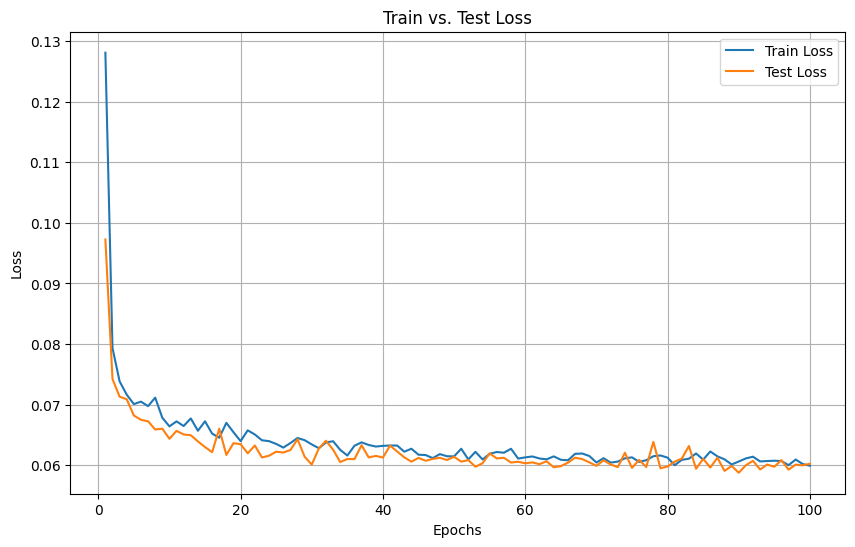

In [407]:
import torch
import matplotlib.pyplot as plt

# Przechowywanie strat
train_losses = []
test_losses = []

# Tryb treningowy modelu
model.train()

# Training loop
for epoch in range(100):
    total_train_loss = 0
    train_batches = 0

    for data_inputs, data_labels in train_data_loader:
        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs.float()).squeeze(dim=1)

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        optimizer.zero_grad()
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        total_train_loss += loss.item()
        train_batches += 1

    avg_train_loss = total_train_loss / train_batches
    train_losses.append(avg_train_loss)

    model.eval() 
    total_test_loss = 0
    test_batches = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_data_loader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)

            test_preds = model(test_inputs.float()).squeeze(dim=1)
            test_loss = loss_module(test_preds, test_labels.float())

            total_test_loss += test_loss.item()
            test_batches += 1

    avg_test_loss = total_test_loss / test_batches
    test_losses.append(avg_test_loss)

    model.train()

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs. Test Loss")
plt.legend()
plt.grid(True)
plt.show()


## Testowanie modelu

In [427]:
model.eval()

for data_inputs, data_labels in test_data_loader:
    data_inputs = data_inputs.to(device)
    data_labels = data_labels.to(device)

    preds = model(data_inputs.float())
    preds = preds.squeeze(dim=1)

    # Convert predictions to class labels
    preds = torch.argmax(preds, dim=1).cpu().numpy()

    # Convert data_labels to class labels
    data_labels = torch.argmax(data_labels, dim=1).cpu().numpy()

    predicted = 0
    for i in range(len(data_labels)):
        if preds[i] == data_labels[i]:
            predicted += 1

    print(f"Accuracy: {predicted/len(data_labels)}")

Accuracy: 0.8775757575757576


## Ewaluacja na docelowym zbiorze testowym

In [429]:
house_data_test = pd.read_csv("test_data.csv")

house_data_test = house_data_test.drop(columns=[])
house_data_test.HeatingType = (house_data_test.HeatingType == "individual_heating").astype(int)
house_data_test.AptManageType = (house_data_test.AptManageType == "management_in_trust").astype(int)

categorical_columns = house_data_test.select_dtypes(include=['object']).columns
house_data_test = pd.get_dummies(house_data_test, columns=categorical_columns)

# -> int
house_data_test = house_data_test.astype(int)

# Normalize data
house_data_test = (house_data_test - house_data_test.mean()) / house_data_test.std()

# Prepare test data
data_inputs = torch.from_numpy(house_data_test.values)
data_inputs = data_inputs.to(device)

# Model predictions
with torch.no_grad():
    preds = model(data_inputs.float()).squeeze(dim=1)

# Convert predictions to class labels
preds = torch.argmax(preds, dim=1)

# Save predictions to a CSV file
pd.DataFrame(preds.cpu()).to_csv("pred.csv", index=False, header=None)